# Analyzing LEGO Mindstorms sound files

2023 Jan 6 - Maarten Pennings

The LEGO Robot Inventor hub runs Python applications.
They are stored on a local file system that also contains other respources.
An example of other resources is sound files; they are found in the directory `/sounds`.

In this notebook we analyse such a file in order to discover the file format.

## What we know
The LEGO [documentation](https://lego.github.io/MINDSTORMS-Robot-Inventor-hub-API/mod_sound.html) states that
_The sound file must be raw 16 bit data at 16 kHz._

So we know
 - the **sample-rate** (number of samples per seconds) is 16kHz.
 - the **sample size** (number of bits per sample) is 16.
 - the **encoding** (what do the bits mean) is "raw" and subject to discovery in the notebook.
 - the **channels** (mono or stereo - or even more) is _assumed_ to be 1 (hub has one speaker).
 
We not only assume the files are _mono_, we also assume the files have _no header_ (since all parameters are fixed by LEGO).

We do not yet know the endianess of the two bytes, or whether the two bytes are signed. And as we will see, not all 16 bits are used.

## The file
I have downloaded some files from the LEGO Robot Inventor hub (directory `/sounds/`), 
and added them to this notebooks directory.

In [1]:
!dir /-C | findstr "startup shutdown"

2023 Jan 06  12:55             65706 menu_shutdown
2023 Jan 06  11:45             39682 startup


From the LEGO documentation we know samples take 16 bits and the rate is 16 kHz. So for `startup` we have

In [2]:
39682/2/16000

1.2400625

The `startup` file has 39682 bytes, and therefore 19841 samples, and is therefore 1.24 seconds long.

## Plotting the file
We assume the samples are stored uncompressed in the file.
Let's read the file in little and big endian, and then plot them.

For plotting we use `matplotlib`.

In [3]:
from matplotlib import pyplot as plt

The following fragment reads the file `startup` and computes two lists:
the little endian and the big endian interpretation.

In [4]:
little_endian = []
big_endian = []
with open('startup','rb') as f:
    bytes2 = f.read(2)
    while len(bytes2)==2 :
        little_endian.append( bytes2[0]+256*bytes2[1] )
        big_endian.append( 256*bytes2[0]+bytes2[1] )
        bytes2 = f.read(2)
    if len(bytes2)!=0 : print('ERROR: file length is not even')

Let's plot the big endian interpretation.

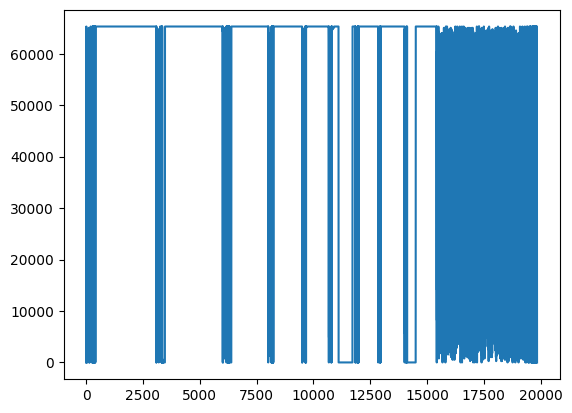

In [5]:
plt.plot(big_endian);

Does not look right. Let's plot the little endian interpretation.

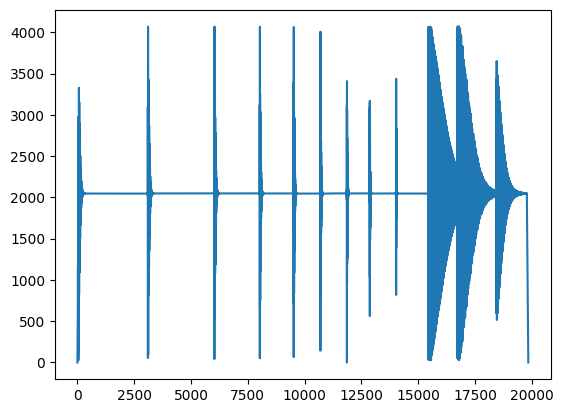

In [6]:
plt.plot(little_endian);

Looks much better.

## Checking other file
We now write a _function_ to read the samples from a LEGO sound file (in little endianess format).

In [7]:
def readsamples(filename) :
    samples = []
    with open(filename,'rb') as f:
        sample = f.read(2)
        while len(sample)==2 :
            samples.append( sample[0]+256*sample[1] )
            sample = f.read(2)
        if len(sample)!=0 : print('ERROR: file length is not even')
    return samples

We read both sound files.

In [8]:
startup = readsamples('startup')
shutdown = readsamples('menu_shutdown')

Replot the first

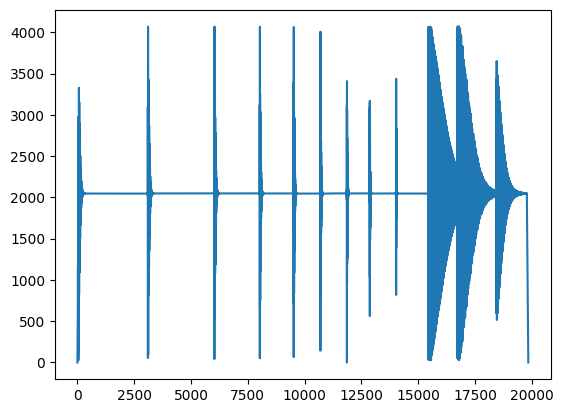

In [9]:
plt.plot(startup);

and plot the second

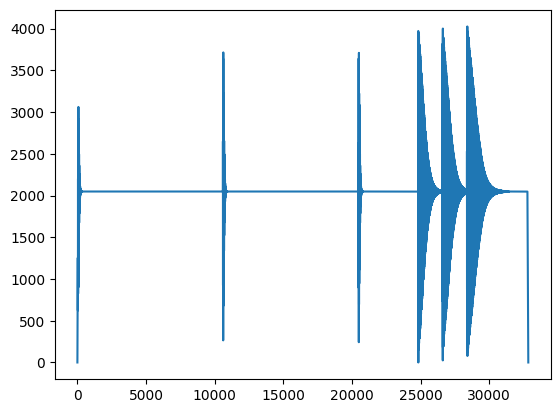

In [10]:
plt.plot(shutdown);

We see some peculiarities. Let's print related key data.

In [11]:
from statistics import mode

def stats(samples) :
    print( f'min   samples: {min(samples)}')
    print( f'max   samples: {max(samples)}')
    print( f'mode  samples: {mode(samples)}')

In [12]:
stats(startup)

min   samples: 0
max   samples: 4071
mode  samples: 2047


In [13]:
stats(shutdown)

min   samples: 0
max   samples: 4025
mode  samples: 2047


The range seems to be 0..4095 (and not -32768..+32767)) and the everage ("silence") halfway (2047).

## Conclusions

From the graphs and key data we draw the following conclusions on the LEGO Mindstorms sound file format
 - Sample rate is 16 kHz
 - One channel (mono)
 - Two bytes (16 bits) per channel in little endian order - "raw" (no compression)
 - No file header
 - Sample uses 12 bit (of the 16) as unsigned
    - min is at 0
    - max is at 4095
    - silence is at 2047

## Appendix 1 - Fade in and out
The graphs show a start and end at level 0.
Let's zoom in on the start of the first graph.

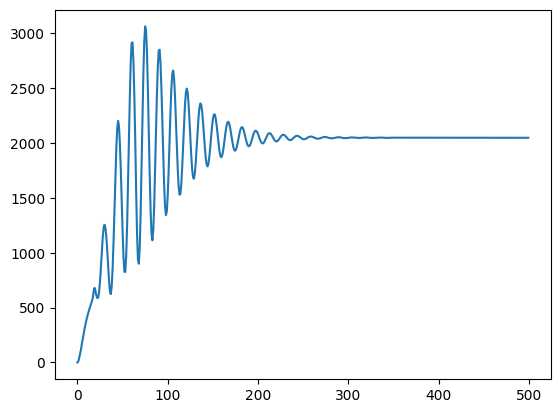

In [14]:
plt.plot(shutdown[:500]);

This is a very funny looking fade-in, because it is not centered around 2048.

Suppose this is the signal we want to send to the speaker.

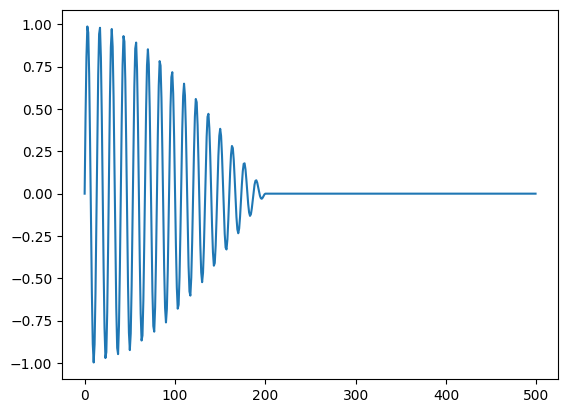

In [15]:
import math
def shape(t,val) : return math.cos(t*3.14/2/200)*val if t<200 else 0
signal = [ shape(t,math.sin(t*15*3.14*2/200)) for t in range(500)]
plt.plot( signal );

Suppose we want a fade-in. Below we use the first quarter of a sine wave as the fade-in enveloppe: 0 at t=0 and 1 at t=pi/2 and beyond. The resulting graph is the expected output, centered around 2048.

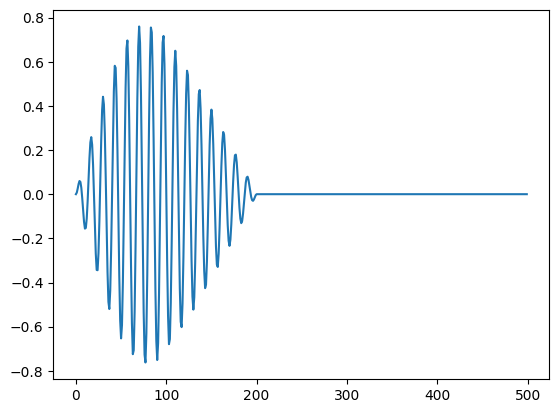

In [16]:
def fade_expected(t,val) :
    val = math.sin(t*3.14/2/100)*val if t<100 else val
    val*2048+2048
    return val
signal_expected = [ fade_expected(t,signal[t]) for t in range(500)]
plt.plot(signal_expected);

However, the LEGO sound file seems to apply the fade-in on the already shifted signal.

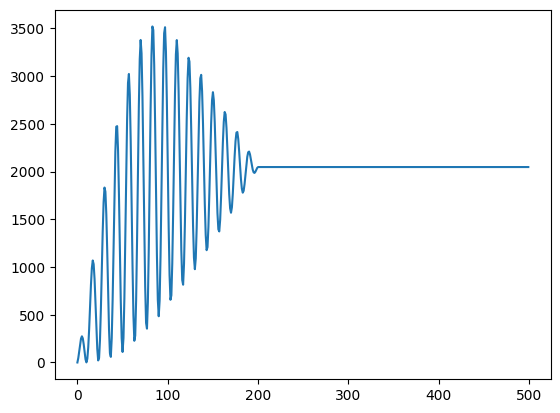

In [17]:
def fade_lego(t,val) :
    val = val*2048+2048
    val = math.sin(t*3.14/2/100)*val if t<100 else val
    return val
signal_lego = [ fade_lego(t,signal[t]) for t in range(500)]
plt.plot(signal_lego);

This latter graph looks very similar to the first 500 samples of the `shutdown` graph: faded around 0, nor around 2048.
To me this looks like a bug...

The fade-in does match with what [Anton](https://antonsmindstorms.com/2021/01/14/advanced-undocumented-python-in-spike-prime-and-mindstorms-hubs/#sound) does

```
sox shake.wav --bits 16 --channels 1 --encoding signed-integer --endian little --rate 16000 
    shake.raw vol 0.0625 dcshift 0.0625 fade h 0.05 -0.05
```

## Appendix 2 - Looking at my sound fragment
I made a `stop.raw` fragment, and also one with Anton's fading `stopfade.raw`.
Let's plot those.

In [18]:
stop = readsamples('../images/stop.raw')

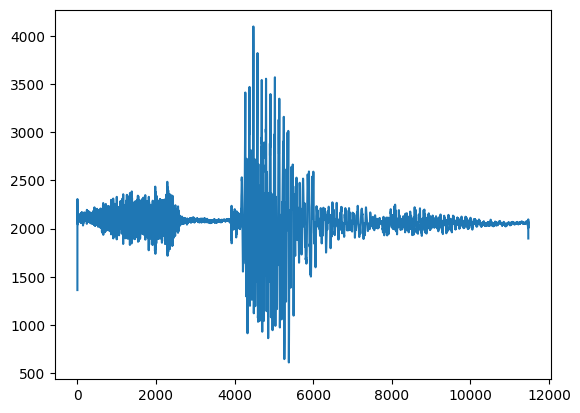

In [19]:
plt.plot(stop);

In [20]:
stats(stop)

min   samples: 611
max   samples: 4096
mode  samples: 2079


Note we have an overflow: at least one sample with value 4096 where the maximum allowed is 4095.

In [21]:
stopfade = readsamples('../images/stopfade.raw')

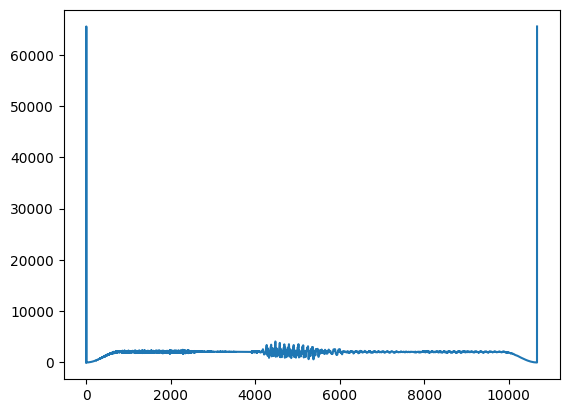

In [22]:
plt.plot(stopfade);

Note that we get funny artefacts at the begin and end.

Conclusion: let's not use the fade, and let's use a volume reduction that is a bit smaller 0.0624 instead of 0.0625.
The file `stop2.raw` is made that way. Let's have a look.

In [23]:
stop2 = readsamples('../images/stop2.raw')

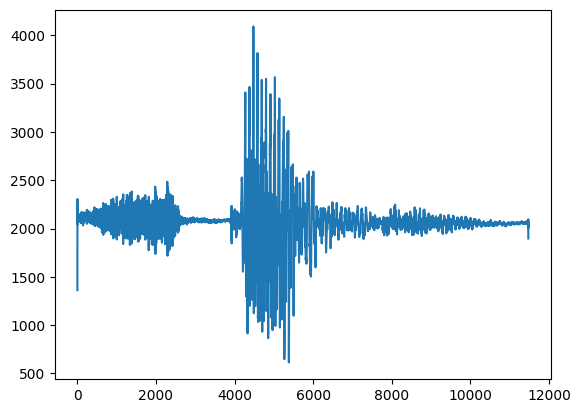

In [24]:
plt.plot(stop2);

In [25]:
stats(stop2)

min   samples: 614
max   samples: 4092
mode  samples: 2081


Looks good, and we hear no more plops!

(end)